This notebook is used to study the long lived veto tagging effects over the 800 run. First the LLVs are studied on a yearly and monthly basis by looking at different events based on their unixtime. The data file LLV_fractions.dat and the PNG images Evis_LLV.png and LLV_fractions.png are produced here.

In [1]:
import ROOT
import ctypes
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from tqdm import tqdm

Welcome to JupyROOT 6.26/04


In [2]:
# Extract time intervals for each year from unixtime info file
dat_file = open("unixtime_info.dat", 'r')
dat_lines = dat_file.readlines()
dat_lines = dat_lines[2:]  # ignore the first and second line of the file

# Create a list of years useful for loops later
year_list = []

for line in dat_lines:
    data = line.strip().split()
    exec(f'unixtime_{data[0]} = {int(data[1]), int(data[2])}')

    year_list.append(int(data[0]))

# Close the data file
dat_file.close()

In [3]:
# Load in root file and get tree data
root_file =  ROOT.TFile("../AllDataZen800Single-DoubleBeta.root")
tree = root_file.Get("nt")

In [4]:
# Functions to read total unixtime, then specifically the year and month
def unixtime_read(tree_input, event):
    
    # Read data from the specified event
    var = ctypes.c_int()
    tree_input.SetBranchAddress("unixtime", var)
    tree_input.GetEntry(event)
    unixtime = var.value
    date_and_time = datetime.fromtimestamp(unixtime)
    
    return date_and_time.timetuple()

def unixtime_year(tree_input, event):
    
    # Read data from the specified event
    var = ctypes.c_int()
    tree_input.SetBranchAddress("unixtime", var)
    tree_input.GetEntry(event)
    unixtime = var.value
    date_and_time = datetime.fromtimestamp(unixtime)
    year = date_and_time.timetuple()[0]
    
    return year

def unixtime_month(tree_input, event):
    
    # Read data from the specified event
    var = ctypes.c_int()
    tree_input.SetBranchAddress("unixtime", var)
    tree_input.GetEntry(event)
    unixtime = var.value
    date_and_time = datetime.fromtimestamp(unixtime)
    month = date_and_time.timetuple()[1]
    
    return month

In [5]:
# Draw Evis comparing the spectra over different time intervals looking at LLV effects

# Load in other root file
root_file_old =  ROOT.TFile("../FileFromArticleSingle-DoubleBeta.root")

# Get tree data
tree_all = root_file.Get("nt")
tree_old = root_file_old.Get("nt")

# Create histogram parameters
Ebin_width = 0.05  # in MeV units
x_min = 0.5
x_max = 5
num_of_bins = int((x_max - x_min)/Ebin_width)

# Create histograms
hist1 = ROOT.TH1F("hist1", "Energy Spectra and the LL veto", num_of_bins, x_min, x_max)
hist2 = ROOT.TH1F("hist2", "LLV Data from Article", num_of_bins, x_min, x_max)
hist3 = ROOT.TH1F("hist3", "LLV Data after Article", num_of_bins, x_min, x_max)
hist4 = ROOT.TH1F("hist4", "Total LLV", num_of_bins, x_min, x_max)

# Define veto criterion
LLV = "LLveto_3D==0"
unixtime_data = "unixtime > 1626910271"  # only include events after the original set of data
combined = LLV + "&&" + unixtime_data

# Select the relevant branch data for each histogram
tree_all.Draw("Evis >> hist1", "", "goff")
tree_old.Draw("Evis >> hist2", LLV, "goff")   # goff means no graphics output
tree_all.Draw("Evis >> hist3", combined, "goff")
tree_all.Draw("Evis >> hist4", LLV, "goff") 

# Create canvas for plotting and draw histograms to it
canvas = ROOT.TCanvas('c1', 'canvas title', 0, 0, 1000, 700)  # last two parameters are graph width and height respectively
hist1.Draw()
hist2.Draw('SAME')
hist3.Draw('SAME')
hist4.Draw('SAME')

# Draw vertical lines to show the region of interest for 0vbb
vertical_line1 = ROOT.TLine(2.35, 1e-1, 2.35, 1e6)
vertical_line2 = ROOT.TLine(2.7, 1e-1, 2.7, 1e6)
vertical_line1.SetLineStyle(ROOT.kDashed)
vertical_line1.SetLineColor(ROOT.kBlack)
vertical_line1.Draw()
vertical_line2.SetLineStyle(ROOT.kDashed)
vertical_line2.SetLineColor(ROOT.kBlack)
vertical_line2.Draw()

# Make a logarithmic y axis
ROOT.gPad.SetLogy()

# Edit the histogram colours
hist1.SetLineColor(ROOT.kRed)
hist2.SetLineColor(ROOT.kBlack)
hist3.SetLineColor(ROOT.kGreen)
hist4.SetLineColor(ROOT.kBlue)

# Create a legend
legend = ROOT.TLegend(0.7, 0.7, 0.9, 0.9)
legend.AddEntry(hist1, "All Data", "L")
legend.AddEntry(hist2, "LLV Data from Article", "L")
legend.AddEntry(hist3, "LLV Data after Article", "L")
legend.AddEntry(hist4, "Total LLV", "L")
legend.Draw()

# Disable the stats box 
hist1.SetStats(0)

# Set axis titles and y axis range
hist1.GetXaxis().SetTitle("Visible Energy (MeV)")
hist1.GetYaxis().SetTitle("Events/0.05MeV")
hist1.GetYaxis().SetRangeUser(0.1, 1e6)

canvas.Update()

# Save the image
canvas.SaveAs("Evis_LLV.png")

Info in <TCanvas::Print>: png file Evis_LLV.png has been created


In [6]:
# Function to measure the amount of LLVs within a time period and check LLV monthly
def LLveto_func_month(tree_input, time_start, time_end):
    
    # Create counters for LLV and total events in the interval for each month
    veto_num = np.zeros(12)
    total_events = np.zeros(12)

    # Set variables to store branch information we're interested in
    LLV_var = ctypes.c_int()
    unixtime_var = ctypes.c_int()
    tree_input.SetBranchAddress("LLveto_3D", LLV_var)
    tree_input.SetBranchAddress("unixtime", unixtime_var)

    # Loop over all events
    num_entries = tree_input.GetEntries()
    for event_num in range(num_entries):
        tree_input.GetEntry(event_num)
        unixtime = unixtime_var.value
        veto_bool = LLV_var.value

        # Check each month
        for i in range(1, 13):
            # Check that we are only looking at a specified time interval (year)
            if unixtime>=time_start and unixtime<=time_end:
                date_and_time = datetime.fromtimestamp(unixtime)
            
                # Store veto information for each month
                if date_and_time.timetuple()[1]==i:
                    total_events[i-1] += 1
                    veto_num[i-1] += veto_bool
    
    return veto_num, total_events

In [7]:
# Determine LLV number and total number of events for each year and month
for year in tqdm(year_list):
    # Determine LLV number and total number of events for each year
    exec(f'LLV_{year} = LLveto_func_month(tree_input=tree, time_start=unixtime_{year}[0], time_end=unixtime_{year}[1])')

    exec(f'LLV_fractions_{year} = np.zeros(12)')
    for i in range(12):
        # Determine LLV fraction for each year and month
        exec(f'LLV_fractions_{year}[i] = LLV_{year}[0][i]/LLV_{year}[1][i]')

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [45:55<00:00, 551.05s/it]


In [8]:
# Save the monthly LLV data to a new file
LLV_file = open("LLV_fractions.dat", "w")

LLV_file.write("# Year    Month    LLV_num    Total_event_num    LLV_fraction \n")
for year in year_list:
    for i in range(12):
        exec(f'LLV_num = LLV_{year}[0][i]')
        exec(f'Total_event_num = LLV_{year}[1][i]')
        exec(f'LLV_fraction = LLV_fractions_{year}[i]')
        LLV_file.write(f"{year}    {i+1}    {int(LLV_num)}    {int(Total_event_num)}    {LLV_fraction}    \n")

LLV_file.close()

In [7]:
# Once the file has been written, read data from it
LLV_file = open("LLV_fractions.dat", "r")
LLV_lines = LLV_file.readlines()
LLV_lines = LLV_lines[1:]  # remove the first line of the file
LLV_lines = LLV_lines[:-7]  # remove the last seven lines of the file (nan fraction values)

# Store data in array
for year in year_list:
    exec(f'LLV_fractions_{year} = np.zeros(12)')
for line in LLV_lines:
    data = line.strip().split()
    exec(f'LLV_fractions_{data[0]}[int(data[1])-1] = {float(data[4])}')

# Close the data file
LLV_file.close()

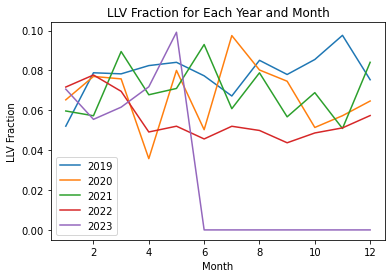

In [8]:
# Now plot the LLV fraction for each year and month
fig, ax = plt.subplots()
for year in year_list:
    exec(f'ax.plot(np.arange(1, 13), LLV_fractions_{year}, label="{year}")')

# Set axis labels and title
ax.set_xlabel("Month")
ax.set_ylabel("LLV Fraction")
ax.set_title("LLV Fraction for Each Year and Month")

# Create a legend
ax.legend();

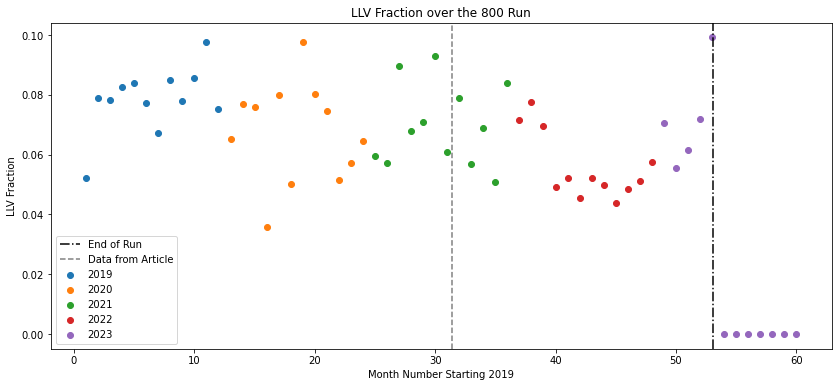

In [9]:
# Now make one plot for all years and save as png

# Edit figure size
plt.figure(figsize=(14, 6))

plt.scatter(np.arange(1, 13), LLV_fractions_2019, label="2019")
plt.scatter(12+np.arange(1, 13), LLV_fractions_2020, label="2020")
plt.scatter(24+np.arange(1, 13), LLV_fractions_2021, label="2021")
plt.scatter(36+np.arange(1, 13), LLV_fractions_2022, label="2022")
plt.scatter(48+np.arange(1, 13), LLV_fractions_2023, label="2023")

# Set axis labels and title
plt.xlabel("Month Number Starting 2019")
plt.ylabel("LLV Fraction")
plt.title("LLV Fraction over the 800 Run")

# Plot vertical lines
plt.axvline(x = 53.1, color = "black", linestyle = "dashdot", label = 'End of Run')
plt.axvline(x = 31.4, color = "gray", linestyle = "dashed", label = 'Data from Article')

# Create a legend
plt.legend()
plt.savefig("LLV_fractions.png");

In [10]:
# Study mean and variance of LLV fractions for each year
for year in year_list:

    # Account for the fact that 2023 only has 5 months of data
    if year==2023:
        array = np.zeros(5)
        for i in range(0,5):
            array[i] = LLV_fractions_2023[i]
        mean = np.mean(array)
        variance = np.var(array)
        exec(f'print("{year} Mean: {mean}")')
        exec(f'print("{year} Variance: {variance}")')
        exec(f'print("")')
        
    else:    
        mean = np.mean(eval(f'LLV_fractions_{year}'))
        variance = np.var(eval(f'LLV_fractions_{year}'))
        exec(f'print("{year} Mean: {mean}")')
        exec(f'print("{year} Variance: {variance}")')
        exec(f'print("")')

2019 Mean: 0.07846848137444094
2019 Variance: 0.0001119694631995491

2020 Mean: 0.06747345907861933
2020 Variance: 0.00025895375698741337

2021 Mean: 0.0698588977751643
2021 Variance: 0.0001738518000915496

2022 Mean: 0.05570751375676725
2022 Variance: 0.00011277893696270965

2023 Mean: 0.07172151614397071
2023 Variance: 0.00022427887516482644

